# Who Has the Highest Salary in Data Science?
---

# Introduction

[This dataset](https://github.com/foorilla/ai-jobs-net-salaries) consists of self-report data from people working in the field of data science in 2020 and 2021, including their roles, salaries, etc. This data is collected by [ai-jobs.net](https://salaries.ai-jobs.net/). The version of the dataset used in this project only includes data from 259 people, however the dataset is regularly updated.

Because this data is self-reported, there may be issues of accuracy in the data. This can be an issue especially in such a small dataset, as it would be easy to bias the data with only a handful of inaccurate values.

In this project, we are attempting to find a link between salary and other variables, so that salary can be predicted. This will be helpful for anyone working in data science - and especially those starting out in the field - to navigate different paths that may affect their current and future salaries.

My hypothesis is that full time jobs where the employee has a high level of experience & the company is in the US will be the highest paid.

---

# Importing & Viewing the Data

In [2]:
# importing all libraries
import numpy as np
import pandas as pd
import re
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics as mt
from math import sqrt
from sklearn.model_selection import cross_val_score

In [42]:
# importing data
salary_data = pd.read_csv('salaries.csv')

In [4]:
# investigating the structure & values of the data
salary_data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021e,MI,FT,Data Engineer,200000,USD,200000,US,100,US,L
1,2021e,EN,FT,Machine Learning Developer,100000,USD,100000,IQ,50,IQ,S
2,2021e,MI,FT,Data Engineer,100000,USD,100000,US,100,US,L
3,2021e,SE,FT,Machine Learning Engineer,70000,EUR,83212,BE,50,BE,M
4,2020,MI,FT,Data Engineering Manager,51999,EUR,59303,DE,100,DE,S
...,...,...,...,...,...,...,...,...,...,...,...
254,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
255,2021e,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
256,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
257,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## Column Label Glossary

### work_year
- The year that the salary was earned
- 2021e: expected in 2021

### experience_level
- EN: Entry-level/Junior
- MI: Mid-level/Intermediate
- SE: Senior-level/Expert
- EX: Executive-level/Director

### employment_type
- PT: Part-time
- FT: Full-time
- CT: Contract
- FL: Freelance

### job_title
- The name of the role worked

### salary
- Total gross salary earned

### salary_currency
- The currency the salary was paid in
- Uses ISO 4217 currency code

### salary_in_usd
- Salary converted to USD
- Uses average USD conversion rate for the year

### employee_residence
- Main country of residence for the employee
- Uses ISO 3166 country code

### remote_ratio
- 0: No remote work (<20%)
- 50: Partially remote
- 100: Fully remote (>80%)

### company_location
- Location of company's main office
- Uses ISO 3166 country code

### company_size
- S: <50 employees
- M: 50-250 employees
- L: >250 employees

---

# Data Cleaning

## Viewing unique values from each column

In [5]:
salary_data['experience_level'].unique()

array(['MI', 'EN', 'SE', 'EX'], dtype=object)

In [6]:
salary_data['employment_type'].unique()

array(['FT', 'PT', 'CT', 'FL'], dtype=object)

In [7]:
salary_data['employee_residence'].unique()

array(['US', 'IQ', 'BE', 'DE', 'FR', 'GB', 'GR', 'RU', 'AT', 'CA', 'UA',
       'NG', 'PK', 'IN', 'ES', 'IT', 'PL', 'BG', 'PH', 'PT', 'HU', 'SG',
       'BR', 'MX', 'TR', 'NL', 'AE', 'JP', 'JE', 'PR', 'RS', 'KE', 'CO',
       'NZ', 'VN', 'IR', 'RO', 'CL', 'DK', 'CN', 'HK', 'SI', 'MD', 'LU',
       'HR', 'MT'], dtype=object)

In [8]:
salary_data['remote_ratio'].unique()

array([100,  50,   0])

In [9]:
salary_data['company_location'].unique()

array(['US', 'IQ', 'BE', 'DE', 'FR', 'GB', 'RU', 'AT', 'CA', 'UA', 'NG',
       'IN', 'ES', 'PL', 'PT', 'DK', 'SG', 'MX', 'TR', 'NL', 'AE', 'JP',
       'CN', 'HU', 'KE', 'CO', 'NZ', 'IR', 'CL', 'PK', 'GR', 'SI', 'BR',
       'CH', 'IT', 'MD', 'LU', 'VN', 'AS', 'HR', 'IL', 'MT'], dtype=object)

In [10]:
salary_data['company_size'].unique()

array(['L', 'S', 'M'], dtype=object)

## Dealing With Countries
- Many of country values for employee_residence & company_location
- Almost half of values in both columns are USA
- Instead of unique values for each country, sort into USA (1) & Not-USA (0) in employee_residence & company_location columns

In [11]:
# counting how many values there are for each country in employee_residence
salary_data['employee_residence'].value_counts()

US    100
IN     22
DE     21
GB     14
FR     14
CA      9
ES      7
JP      4
NL      4
BR      4
GR      4
RU      3
PT      3
PL      3
TR      3
IT      3
PK      3
BE      2
NG      2
VN      2
HU      2
DK      2
AT      2
MX      2
SG      2
RO      2
MT      1
HR      1
PR      1
RS      1
CN      1
IR      1
IQ      1
BG      1
AE      1
LU      1
KE      1
CO      1
SI      1
HK      1
NZ      1
CL      1
PH      1
MD      1
JE      1
UA      1
Name: employee_residence, dtype: int64

<AxesSubplot:title={'center':'Count of Countries in employee_residence'}, xlabel='Country', ylabel='Count'>

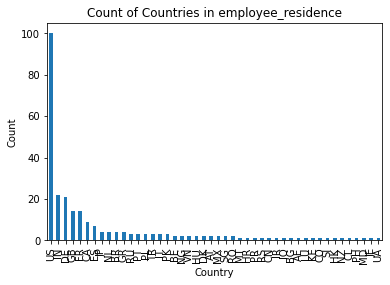

In [45]:
# visually plotting how many values are in each country
salary_data['employee_residence'].value_counts().plot(kind='bar', title='Count of Countries in employee_residence', ylabel='Count', xlabel='Country')

In [13]:
# counting how many values there are for each country in company_location
salary_data['company_location'].value_counts()

US    116
DE     21
GB     17
IN     17
FR     12
CA     11
ES      7
JP      4
TR      3
NL      3
AT      3
DK      3
PL      3
BE      2
NG      2
PK      2
PT      2
LU      2
GR      2
MX      2
BR      2
RU      2
CN      2
MT      1
CL      1
IQ      1
SG      1
MD      1
VN      1
AE      1
HU      1
CH      1
KE      1
CO      1
AS      1
SI      1
HR      1
NZ      1
IT      1
IL      1
IR      1
UA      1
Name: company_location, dtype: int64

<AxesSubplot:title={'center':'Count of Countries in company_location'}, xlabel='Country', ylabel='Count'>

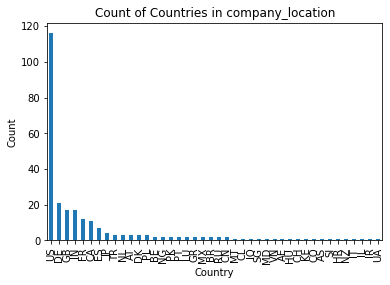

In [46]:
# visually plotting how many values are in each country
salary_data['company_location'].value_counts().plot(kind='bar', title='Count of Countries in company_location', ylabel='Count', xlabel='Country')

## Map Dictionaries onto Column Values

In [47]:
# creating dictionaries to convert column values
experience_conversion = {'MI':2, 'EN':1, 'SE':3, 'EX':4}
employment_type_conversion = {'FT': 'full_time', 'PT': 'part_time', 'CT': 'contract', 'FL': 'freelance'}
employee_residence_conversion = {'US': 1, 'IQ': 0, 'BE': 0, 'DE': 0, 'FR': 0, 'GB': 0, 'GR': 0, 'RU': 0, 'AT': 0, 'CA': 0, 'UA': 0,
       'NG': 0, 'PK': 0, 'IN': 0, 'ES': 0, 'IT': 0, 'PL': 0, 'BG': 0, 'PH': 0, 'PT': 0, 'HU': 0, 'SG': 0,
       'BR': 0, 'MX': 0, 'TR': 0, 'NL': 0, 'AE': 0, 'JP': 0, 'JE': 0, 'PR': 0, 'RS': 0, 'KE': 0, 'CO': 0,
       'NZ': 0, 'VN': 0, 'IR': 0, 'RO': 0, 'CL': 0, 'DK': 0, 'CN': 0, 'HK': 0, 'SI': 0, 'MD': 0, 'LU': 0,
       'HR': 0, 'MT': 0}
remote_conversion = {100: 'remote', 50: 'mixed', 0: 'office'}
company_location_conversion = {'US': 1, 'IQ': 0, 'BE': 0, 'DE': 0, 'FR': 0, 'GB': 0, 'RU': 0, 'AT': 0, 'CA': 0, 'UA': 0, 'NG': 0,
       'IN': 0, 'ES': 0, 'PL': 0, 'PT': 0, 'DK': 0, 'SG': 0, 'MX': 0, 'TR': 0, 'NL': 0, 'AE': 0, 'JP': 0,
       'CN': 0, 'HU': 0, 'KE': 0, 'CO': 0, 'NZ': 0, 'IR': 0, 'CL': 0, 'PK': 0, 'GR': 0, 'SI': 0, 'BR': 0,
       'CH': 0, 'IT': 0, 'MD': 0, 'LU': 0, 'VN': 0, 'AS': 0, 'HR': 0, 'IL': 0, 'MT': 0}


In [48]:
# map all dictionaries onto columns to replace column values
salary_data['experience'] = salary_data['experience_level'].map(experience_conversion)
salary_data['work_type'] = salary_data['employment_type'].map(employment_type_conversion)
salary_data['usa_employee'] = salary_data['employee_residence'].map(employee_residence_conversion)
salary_data['remote_status'] = salary_data['remote_ratio'].map(remote_conversion)
salary_data['usa_company'] = salary_data['company_location'].map(company_location_conversion)

## Create Job Category Column
- There are many unique job titles
- Want to simplify them by sorting into different job categories
- Need to create a function that finds key words in job titles & categorizes jobs based on them, making a new job_category column

In [17]:
# view all unique job titles
salary_data['job_title'].unique()

array(['Data Engineer', 'Machine Learning Developer',
       'Machine Learning Engineer', 'Data Engineering Manager',
       'Research Scientist', 'Data Architect', 'BI Data Analyst',
       'Director of Data Science', 'Big Data Engineer',
       'Data Science Consultant', 'Data Scientist',
       'Head of Data Science', 'Head of Data', 'Data Analytics Manager',
       'Data Analyst', 'Data Science Engineer', 'Manager Data Science',
       'AI Scientist', '3D Computer Vision Researcher', 'ML Engineer',
       'Applied Data Scientist', 'Data Analytics Engineer',
       'Lead Data Analyst', 'Machine Learning Scientist',
       'Machine Learning Infrastructure Engineer',
       'Marketing Data Analyst', 'Lead Data Engineer',
       'Director of Data Engineering',
       'Computer Vision Software Engineer', 'Financial Data Analyst',
       'Cloud Data Engineer', 'Principal Data Analyst',
       'Big Data Architect', 'Lead Data Scientist',
       'Staff Data Scientist', 'Data Science Manage

### Sorting Job Titles
- Contains 'Manager' or 'Head' = 'manager'
- Contains 'Engineer', 'Engineering', 'Architect', or 'Developer' = 'engineer'
- Contains 'Analyst', 'Analytics', or 'Specialist' = 'analyst'
- Contains 'Scientist', 'Researcher', or 'Science' = 'scientist'
- Note: these may need to be expanded pending new data

In [77]:
# creating a list of lists containing each word in each job title
word_list = [original_title.split() for original_title in copy.copy(salary_data['job_title'])]

In [78]:
# creating a function to iterate through job titles & create a list of job categories
def simplify_title(sublst):
    simple_title = []
    for word in sublst:
        if word == 'Manager' or word == 'Head':
            simple_title.append('manager')
            break
        elif word == 'Engineer' or word == 'Engineering' or word == 'Architect' or word == 'Developer':
            simple_title.append('engineer')
            break
        elif word == 'Analyst' or word == 'Analytics' or word == 'Specialist':
            simple_title.append('analyst')
            break
        elif word == 'Scientist' or word == 'Researcher' or word == 'Science':
            simple_title.append('scientist')
            break
        
    return simple_title

# applying the function onto the list of words in each job title
job_category = list(map(simplify_title, word_list))

In [79]:
# converting the job_category to a DataFrame
job_category = pd.DataFrame(job_category)

In [80]:
# viewing the new column
job_category

,0
0,engineer
1,engineer
2,engineer
3,engineer
4,engineer
...,...
254,scientist
255,scientist
256,scientist
257,analyst


In [81]:
# combining the original data with the new job_category column
# use an inner join, which will include only data that has a match in the other DataFrame
salary_data = pd.merge(salary_data, job_category, how='inner', left_index=True, right_index=True)

In [82]:
# renaming the new column to 'job_category' in the DataFrame
salary_data.rename(columns={0:'job_category'}, inplace=True)

In [83]:
# export this version of the data for use in Tableau
# still contains redundant columns & detailed country data
salary_data.to_csv('./capstone_regression_data_redundant_columns.csv', index=False)

In [84]:
# remove unnecessary or redundant columns
salary_data.drop(columns=['job_title', 'work_year', 'experience_level', 'employment_type', 'salary', 'salary_currency', 'employee_residence', 'remote_ratio', 'company_location'], inplace=True)


---
# Exploratory Analysis

## Salary

### Salary Count
- Can see that salary is negatively skewed with some very high outliers
- Most common salary is around $100 000 USD

<AxesSubplot:title={'center':'Salary Frequency'}, ylabel='Frequency'>

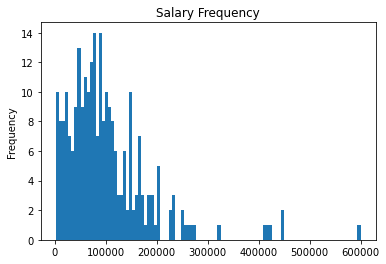

In [62]:
# plotting the frequency of reported salaries
salary_data['salary_in_usd'].plot.hist(title='Salary Frequency', bins=100, xlabel='Salary')

## Company Size

### Company Size Count
- Most companies are large (>250 employees)

<AxesSubplot:title={'center':'Count of Company Sizes'}, xlabel='Company Size', ylabel='Count'>

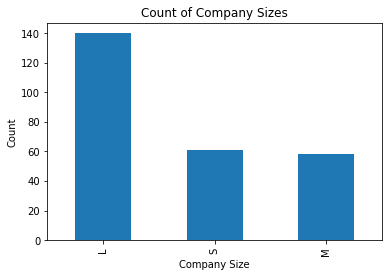

In [57]:
# plotting the number of values in each company size
salary_data['company_size'].value_counts().plot(kind='bar', title='Count of Company Sizes', xlabel='Company Size', ylabel='Count')

### Mean Salary by Company Size
- Employees at large companies seem to make slightly higher salaries on average

<AxesSubplot:title={'center':'Mean Salary by Company Size'}, xlabel='Company Size', ylabel='Mean Salary'>

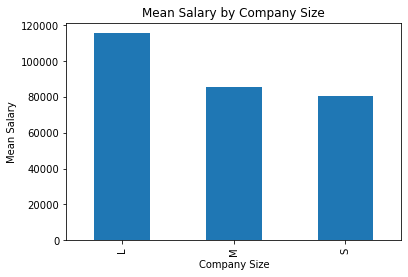

In [59]:
# plotting the mean salary for each company size
salary_data.groupby('company_size')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary by Company Size', ylabel='Mean Salary', xlabel='Company Size')

## Experience

### Experience Count
- There are very few people in executive or director roles
- This may have a negative impact on predictive power

<AxesSubplot:title={'center':'Frequency of Experience Level'}, ylabel='Frequency'>

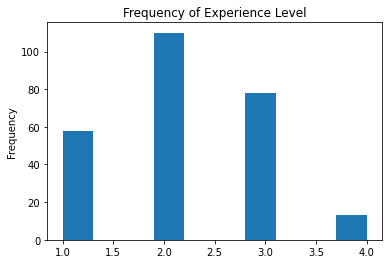

In [63]:
# plotting the number of values at each level of experience
salary_data['experience'].plot.hist(title='Frequency of Experience Level', xlabel='Experience Level')

### Mean Salary by Experience
- As we would expect, salary increases as experience level increases

<AxesSubplot:title={'center':'Mean Salary by Experience'}, xlabel='Experience', ylabel='Mean Salary (USD)'>

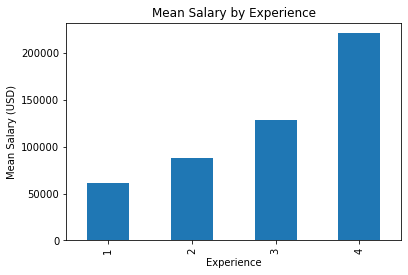

In [64]:
# plotting mean salary at each experience level
salary_data.groupby('experience')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary by Experience', ylabel='Mean Salary (USD)', xlabel='Experience')

## Work Type

### Work Type Count
- keep an eye on this because it is unbalanced
- for now we will keep this variable in the analysis, but will be skeptical of its predictive power

<AxesSubplot:title={'center':'Frequency of Work Types'}, xlabel='Work Type', ylabel='Frequency'>

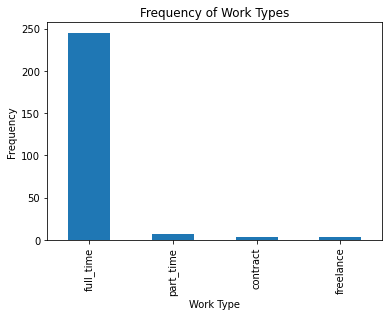

In [68]:
# plotting the number of values in each work type
salary_data['work_type'].value_counts().plot(kind='bar', title='Frequency of Work Types', xlabel='Work Type', ylabel='Frequency')

### Mean Salary by Work Type
- Contract workers have a much higher mean salary
- Because there are so few values in every category other than full_time, this effect could have been caused by an outlier, so we will remain skeptical

<AxesSubplot:title={'center':'Mean Salary by Work Type'}, xlabel='Work Type', ylabel='Mean Salary (USD)'>

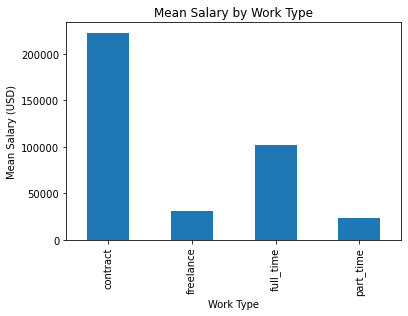

In [66]:
# plotting mean salary for each work type
salary_data.groupby('work_type')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary by Work Type', xlabel='Work Type', ylabel='Mean Salary (USD)')

## Employee Country
- We can see that almost 40% of respondents are from the USA
- Instead of including every country, make 2 groups: USA & Not-USA

### USA & Not-USA Country Count

<AxesSubplot:title={'center':'Frequency of USA & Not-USA Employee Country'}, xlabel='USA Status', ylabel='Frequency'>

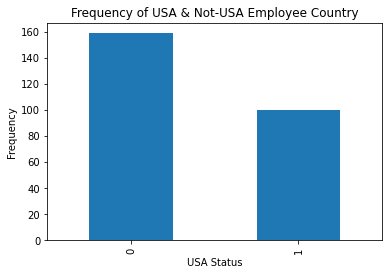

In [69]:
# plotting the number of values for employees living in & outside of the USA
salary_data['usa_employee'].value_counts().plot(kind='bar', title='Frequency of USA & Not-USA Employee Country', xlabel='USA Status', ylabel='Frequency')

## Mean Salary by USA or Not-USA
- The mean salary for employees living inside the USA is much higher than those outside the USA

<AxesSubplot:title={'center':'Mean Salary of USA & Not-USA Employee Country'}, xlabel='USA Status', ylabel='Mean Salary'>

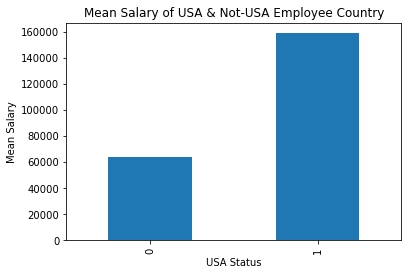

In [70]:
# plotting mean salary for employees living in & outside of the USA
salary_data.groupby('usa_employee')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary of USA & Not-USA Employee Country', xlabel='USA Status', ylabel='Mean Salary')

## Remote Status
### Remote Status Count
- More employees work remotely than in the office or partially remote
- This is also an interesting finding in the context of the current job landscape

<AxesSubplot:title={'center':'Frequency of Remote Status'}, xlabel='Remote Status', ylabel='Frequency'>

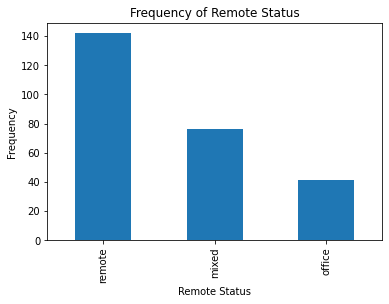

In [71]:
# plotting the number of values in each category of remote status
salary_data['remote_status'].value_counts().plot(kind='bar', title='Frequency of Remote Status', xlabel='Remote Status', ylabel='Frequency')

### Mean Salary by Remote Status
- Remote workers make slightly more on average

<AxesSubplot:title={'center':'Mean Salary by Remote Status'}, xlabel='Remote Status', ylabel='Mean Salary (USD)'>

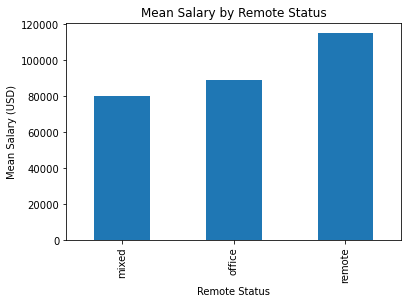

In [75]:
# plotting mean salary by remote status
salary_data.groupby('remote_status')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary by Remote Status', xlabel='Remote Status', ylabel='Mean Salary (USD)')

## Company Country
- Again, group company_country by USA & Not-USA

### Company Country Count

<AxesSubplot:title={'center':'Frequency of USA & Not-USA Company Country'}, xlabel='USA Status', ylabel='Frequency'>

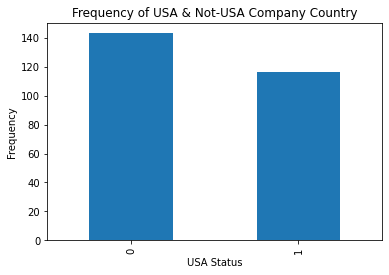

In [73]:
# plotting the number of values for companies in & outside of the USA 
salary_data['usa_company'].value_counts().plot(kind='bar', title='Frequency of USA & Not-USA Company Country', xlabel='USA Status', ylabel='Frequency')

### Mean Salary by Company Country
- Salaries for employees working at American companies are higher on average

<AxesSubplot:title={'center':'Mean Salary of USA & Not-USA Company Country'}, xlabel='USA Status', ylabel='Mean Salary (USD)'>

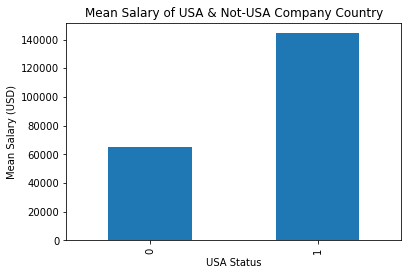

In [74]:
# plotting mean salary for employees at companies in & outside of the USA
salary_data.groupby('usa_company')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary of USA & Not-USA Company Country', xlabel='USA Status', ylabel='Mean Salary (USD)')

## Job Category

### Job Category Count
- There are very few people in manager positions
- We will keep this in mind, as it may reduce predictive power

<AxesSubplot:title={'center':'Frequency of Job Categories'}, xlabel='Job Category', ylabel='Frequency'>

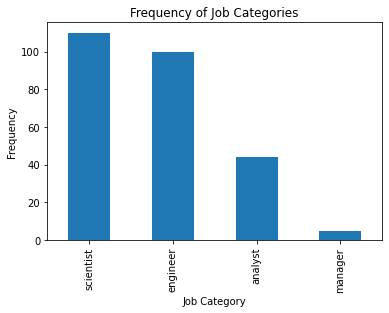

In [85]:
# plotting the number of values in each job category
salary_data['job_category'].value_counts().plot(kind='bar', title='Frequency of Job Categories', xlabel='Job Category', ylabel='Frequency')

### Mean Salary by Job Category
- Managers make higher salaries on average
- Because there are so few values in the manager category, we will remain skeptical of this finding

<AxesSubplot:title={'center':'Mean Salary by Job Category'}, xlabel='Job Category', ylabel='Mean Salary (USD)'>

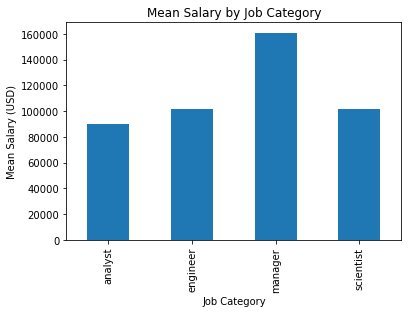

In [86]:
# plotting mean salaries for each job category
salary_data.groupby('job_category')['salary_in_usd'].mean().plot(kind='bar', title='Mean Salary by Job Category', xlabel='Job Category', ylabel='Mean Salary (USD)')

## One-Hot Encoding

In [1210]:
# make categorical columns into numeric columns so that they can be included in the linear regression
regression_data = pd.get_dummies(data=salary_data, columns=['company_size', 'work_type', 'remote_status', 'job_category'])

## Descriptive Statistics of Variables

In [1119]:
# getting descriptive statistics of columns of interest
regression_data.describe()

,salary_in_usd,experience,usa_employee,usa_company,company_size_L,company_size_M,company_size_S,work_type_contract,work_type_freelance,work_type_full_time,work_type_part_time,remote_status_mixed,remote_status_office,remote_status_remote,job_category_analyst,job_category_engineer,job_category_manager,job_category_scientist
count,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000,259.000000
mean,100582.328185,2.177606,0.386100,0.447876,0.540541,0.223938,0.235521,0.015444,0.011583,0.945946,0.027027,0.293436,0.158301,0.548263,0.169884,0.386100,0.019305,0.424710
std,82808.943578,0.834875,0.487797,0.498238,0.499319,0.417688,0.425146,0.123549,0.107206,0.226562,0.162476,0.456218,0.365730,0.498629,0.376258,0.487797,0.137861,0.495256
min,2871.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47312.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,82856.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,130781.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,600000.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Correlation Matrix
- Note that salary_in_usd is correlated with several other variables
- This is a good sign for regression modelling

<AxesSubplot:>

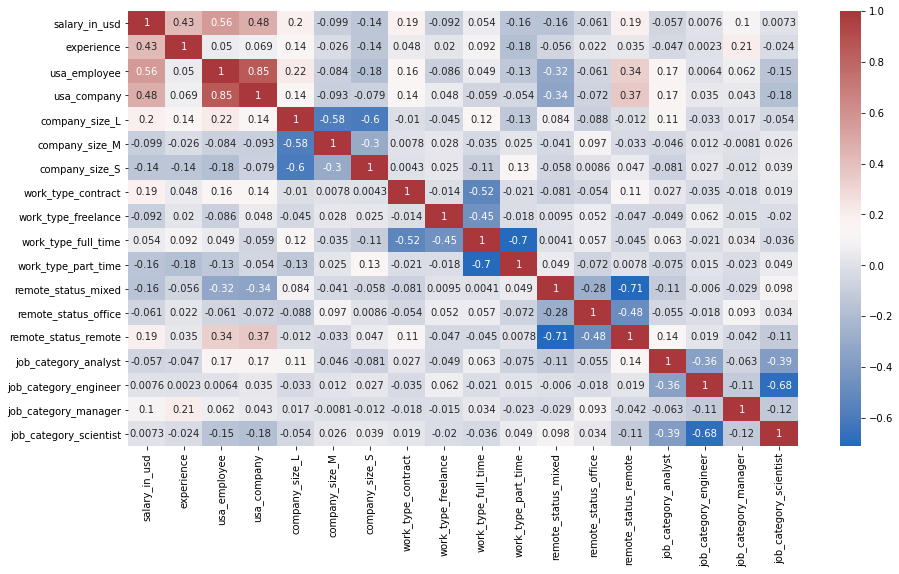

In [1211]:
# creating a heat map of all variable correlations
plt.figure(figsize=(15,8))
sns.heatmap(regression_data.corr(), annot=True, cmap='vlag')

## Plotting Correlation Coefficients
- Shows which columns account for more variance/predictive power in relation to the dependent variable
- Several variables have near-zero coefficients, showing that they have little effect on the dependent variable
- We can use this to decide which variables can be dropped before the main analysis

<AxesSubplot:>

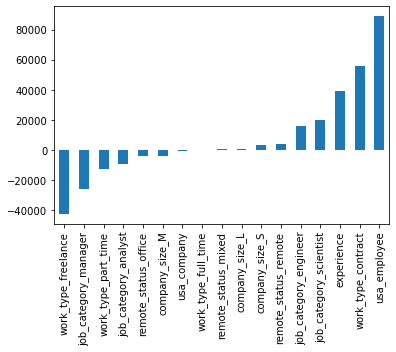

In [1121]:
# plotting correlation coefficients
coeff = pd.Series(data=lr.coef_, index=X.columns).sort_values()
coeff.plot(kind='bar')

In [1122]:
# dropping columns with very low correlation coefficients
regression_data = regression_data.drop(columns=['remote_status_office', 'company_size_M', 'usa_company', 'work_type_full_time', 'remote_status_mixed', 'company_size_L', 'company_size_S', 'remote_status_remote'])

---
# Main Analyses
- Because we are predicting a continuous, numeric variable (salary), we will use regression modelling

## Linear Regression Attempt 1
- Adjusted r-squared is fairly low, so we will try to improve the model

In [1142]:
# defining dependent & independent variables & adding the constant
# dependent variable is rating
dep_var = regression_data['salary_in_usd']
#independent variables are all columns except rating
ind_vars = regression_data.drop('salary_in_usd', axis=1)
# constant = 1
ind_vars['constant'] = 1

In [1143]:
# running the linear regression
lin_reg = sm.OLS(dep_var, ind_vars)
reg_results = lin_reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     31.51
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           6.16e-34
Time:                        17:22:09   Log-Likelihood:                -3209.7
No. Observations:                 259   AIC:                             6437.
Df Residuals:                     250   BIC:                             6469.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
experience              3.85

## Linear Regression Attempt 2
- Removed work_type_freelance, work_type_part_time, job_category_engineer, job_category_manager, & job_category_scientist from the model because of their high p-values
- Recall that we were skeptical of the predictive power of all work types, as well as the manager job category

In [1144]:
# removing columns with highest p-values
ind_vars2 = ind_vars.drop(columns=['work_type_freelance', 'work_type_part_time', 'job_category_engineer', 'job_category_manager', 'job_category_scientist'])

In [1145]:
# running the linear regression
lin_reg2 = sm.OLS(dep_var, ind_vars2)
reg_results2 = lin_reg2.fit()
print(reg_results2.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     62.42
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           1.11e-36
Time:                        17:22:37   Log-Likelihood:                -3211.3
No. Observations:                 259   AIC:                             6433.
Df Residuals:                     254   BIC:                             6450.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
experience            3.841e+04 

## Linear Regression Attempt 3
- Removed work_type_contract
- The adjusted r-squared has not increased, however we have simplified the model, removed unnecessary variables, & have a very low p-value

In [1146]:
# removing column with highest p-value
ind_vars3 = ind_vars2.drop(columns=['work_type_contract'])

In [1147]:
# running the linear regression
lin_reg3 = sm.OLS(dep_var, ind_vars3)
reg_results3 = lin_reg3.fit()
print(reg_results3.summary())

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     81.34
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           5.98e-37
Time:                        17:23:06   Log-Likelihood:                -3213.1
No. Observations:                 259   AIC:                             6434.
Df Residuals:                     255   BIC:                             6448.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
experience            3.875e+04 

## Test/Train Logistic Regression
- Because of the small dataset, the test set is smaller than we would like
- Also because of the small dataset, we have set the test size to 10% of the data

In [1148]:
# defining independent variables
X = ind_vars3
# defining dependent variable
y = dep_var

In [1149]:
# creating test & train sets for independent & dependent variables
# because of small dataset, only using 10% of data for test set, but not ideal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=175)

In [1214]:
# viewing the size & shape of the sets that were created
# each train set has 233 rows, & each test set has 26 rows
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(233, 4)
(26, 4)
(233,)
(26,)


In [1151]:
# fitting the linear regression
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

## Predicting Values Using the Model

In [1152]:
# getting salary values when test values are entered
y_pred = lr.predict(X_test)

## Evaluating the Model
- On average, the salary prediction is off by $68 946.61
- The model has moderate predictive power for predicting salaries

In [1212]:
# calculating RMSE
print('RMSE:',np.round(sqrt(mt.mean_squared_error(y_test,y_pred)),2))

# calculating R-Square; closer to 1 is better
print('R-Squared:',np.round(mt.r2_score(y_test,y_pred),2))

RMSE: 68946.61
R-Squared: 0.44


#### Cross Validation
- Checking the model again by increasing the amount of test data
- The mean cross-validation score is close to the R-squared score above, indicating that it is an accurate assessment
- This is an especially important step because of our small test set

In [1160]:
# finding the cross-validation score using 5 folds
print(np.mean(cross_val_score(lr, X_train, y_train, cv=5)))

0.4736845985353641


---
# Ethical Concerns/Implications
This dataset is published in the public domain, so there are few ethical concerns surrounding its use. It does still contain sensitive and personal information about individuals, however. Because information for the dataset is submitted anonymously, the website collecting and distributing the data has taken care to protect the identities of those who submit personal details. As well, the website actively strives for higher salary transparency, so presumably those people submitting their salaries will also have consistent beliefs, and be comfortable with their information being somewhat public.

---
# Conclusion: Who has the highest salary?
- An employee who has a high level of experience, lives in the USA, and is not an analyst.
- They have a predicted salary of $232 909.17.
- This does not fully align with my hypothesis, though I did predict that high experience would predict salary.

In [1175]:
# predicting the highest salary based on the model
print(lr.predict([[4, 1, 0, 1]]))

[232909.17720488]
